In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import random


/Users/mwoods/Developer/open-ai-gym/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
env = gym.make('CartPole-v0')
path_to_recording = './tmp/CartPole-v0-gradient'

[2017-01-03 22:36:44,756] Making new env: CartPole-v0


In [3]:
def policy_gradient():
    
    """
    updates the policy gradient based on receiveing a state tensor and an action tensor 
    """
    state = tf.placeholder(dtype = tf.float32, shape = (None, 4))
    actions = tf.placeholder(dtype = tf.float32, shape  = (None, 2))
    advantage = tf.placeholder(dtype = tf.float32, shape  = (None, 1))
    
    linear_weights = tf.Variable(tf.zeros((4, 2)))
    linear = tf.matmul(state, linear_weights)
    est_probs = tf.nn.softmax(linear)
    
    acc = tf.reduce_sum(tf.mul(est_probs, actions), reduction_indices = [1])
    log_probs = tf.log(acc)
    loss = -tf.reduce_sum(log_probs * advantage)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    return optimizer, state, actions, advantage, est_probs, loss, linear_weights


def value_gradient():
    """
    a 2 layer Feed Forward Net to estimate the value as a function of the state vector
    """
    state = tf.placeholder(dtype=tf.float32, shape = (None, 4))
    val = tf.placeholder(dtype=tf.float32, shape = (None, 1))
    
    w1 = tf.Variable(tf.truncated_normal([4, 10], stddev=0.1))
    b1 = tf.Variable(tf.truncated_normal([10], stddev=0.1))
    h1 = tf.nn.relu(tf.matmul(state, w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([10, 1], stddev=0.1))
    b2 = tf.Variable(tf.truncated_normal([1], stddev=0.1))
    val_est = tf.matmul(h1, w2) + b2
    
    loss = tf.nn.l2_loss(val_est - val) #square error
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    return optimizer, state, val, val_est, loss

In [4]:
np.random.seed(42)
tf.set_random_seed(42)

policy_opt, policy_state_var, policy_action_var, policy_advantages_var,  policy_action_est, policy_loss, wts = policy_gradient()
value_opt, value_state_var, value_val_var, value_val_est, value_loss = value_gradient()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

TOTAL_NUMBER_OF_TRAINING_EPISODES = 0
pol_loss_hist = []
val_loss_hist = []
reward_hist = []
mean_max_prob = []
mean_advantage = []

In [5]:
num_episodes = 2500
gamma = 0.97


 
print 'Total # of episodes trained so far', TOTAL_NUMBER_OF_TRAINING_EPISODES
for epoch in xrange(num_episodes):
    TOTAL_NUMBER_OF_TRAINING_EPISODES += 1
    obs = env.reset()
    states = []
    actions = []
    transitions = []
    total_reward = 0.0
    max_prob_per_step = []
    while True:
        probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})
        #THIS EXPLORATION FUNCTION IS THE MOST CRITICAL PART TO THE SUCCESS of the model. WHY???
        
        action = 0 if np.random.rand() < probs[0][0] else 1 #intresting approach.. as you get more confident in your answers the model will start to scale down
        max_prob = probs.max()
        #print obs
        #print action, probs
        
        action_arr = np.zeros(2)
        action_arr[action] = 1.0

        next_obs, reward, done, _ = env.step(action)

        states.append(obs)
        actions.append(action_arr)
        transitions.append((next_obs, reward, done))

        total_reward += reward
        max_prob_per_step.append(max_prob)
        obs = next_obs
        if done or total_reward > 500:
            break
    
    
    future_rewards = []
    for idx, trans in enumerate(transitions):
        obs, rew, done = trans
        cum_reward = 0.0
        for idx2, future_trans in enumerate(transitions[idx:]):
            _, future_reward, _ = future_trans
            #print (gamma**idx2) * future_reward
            cum_reward += (gamma**idx2) * future_reward
        
        future_rewards.append([cum_reward])
    

    #calculate the difference between the true reward and the estimated value
    #if the policy suggests an action, but the true future reward is worse than the predicted result, then it will increase
    #the loss score, which will pull t he policy in the other direction
    N = len(states) #batch size
    obs_ = [obs for obs, _, _ in  transitions]
    estimated_val = sess.run(value_val_est, feed_dict = {value_state_var : obs_})
    
    #in regards to calculate the advantages larges values (in the 10s) seem to produce noticeably better results then 
    #normalizing either the future rewards or the advantages given this particular architecture.
    
    future_rewards =  np.array(future_rewards)
    #future_rewards = (future_rewards - future_rewards.mean())/future_rewards.std()
    
    advantage = (future_rewards - estimated_val) 
    #advantage = (advantage - advantage.mean())/advantage.std()

    pol_opt, pol_loss = sess.run([policy_opt, policy_loss], feed_dict = {policy_state_var: states, 
                                                                         policy_action_var: actions,
                                                                         policy_advantages_var: advantage
                                                                        })
    
    val_opt, val_loss = sess.run([value_opt, value_loss], feed_dict = {value_state_var: states, value_val_var: future_rewards})
    
    #normalizing loss by batch size
    pol_loss_hist.append(pol_loss/N)
    val_loss_hist.append(val_loss/N)
    reward_hist.append(total_reward)
    mean_max_prob.append(np.array(max_prob_per_step).mean())
    mean_advantage.append(advantage.mean())
    if epoch % 10 == 0:
        print 'episode', epoch, 'total_reward', total_reward, pol_loss, val_loss, advantage.mean(), advantage.max(), advantage.min()
    
    #if sum(reward_hist[-100:])/100.0 > 250:
    #    break
        

print 'Total # of episodes trained so far', TOTAL_NUMBER_OF_TRAINING_EPISODES


Total # of episodes trained so far 0
episode 0 total_reward 28.0 6122.11 2185.48 11.2657390852 19.1463453243 1.02091923356
episode 10 total_reward 18.0 1791.57 729.335 8.07424856701 14.0763906648 1.01616098173
episode 20 total_reward 18.0 1771.48 727.367 8.05913729411 14.0659668779 0.998101795092
episode 30 total_reward 41.0 16355.2 5264.8 14.5733899488 23.7562055083 0.996336283395
episode 40 total_reward 11.0 550.86 200.191 5.39086060208 9.46364362098 0.93317347765
episode 50 total_reward 22.0 3021.02 1198.51 9.36723431894 16.2410137724 0.964321821928
episode 60 total_reward 22.0 3067.35 1195.76 9.34736965986 16.2289193865 0.925875432789
episode 70 total_reward 25.0 4284.3 1636.07 10.2747921008 17.694228194 0.908898994327
episode 80 total_reward 51.0 28196.2 8376.16 16.5771191059 26.1929617928 0.907291904092
episode 90 total_reward 12.0 592.537 245.031 5.68653507177 10.0891320301 0.846133187413
episode 100 total_reward 35.0 10550.0 3622.75 12.9989012292 21.7141992337 0.809913426638
ep

In [6]:
smoothed_pol_loss_hist = [sum(pol_loss_hist[i-99:i])/100.0 for i in range(99, len(pol_loss_hist)) ]
smoothed_val_loss_hist = [sum(val_loss_hist[i-99:i])/100.0 for i in range(99, len(val_loss_hist)) ]
smoothed_reward_hist   = [sum(reward_hist[i-99:i])/100.0 for i in range(99, len(reward_hist)) ]
smoothed_mean_max_prob = [sum(mean_max_prob[i-99:i])/100.0 for i in range(99, len(mean_max_prob))]
smoothed_mean_advantage = [sum(mean_advantage[i-99:i])/100.0 for i in range(99, len(mean_advantage))]

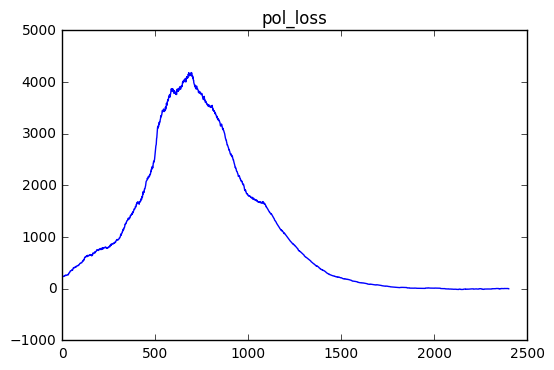

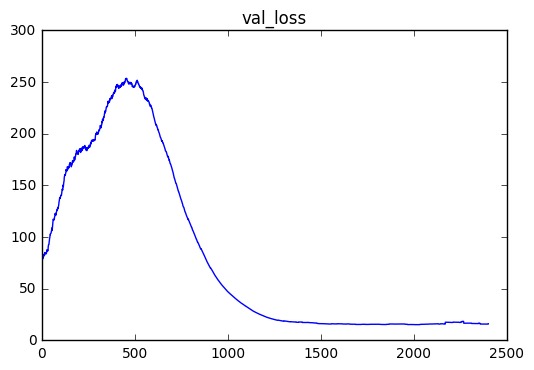

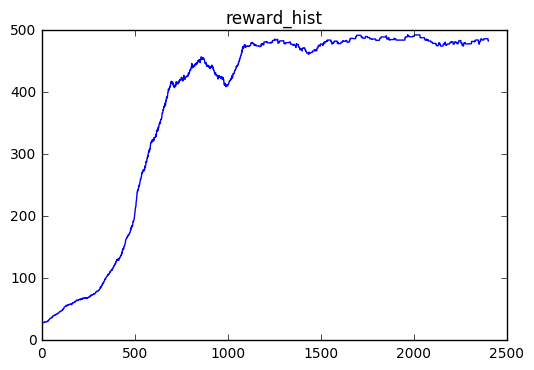

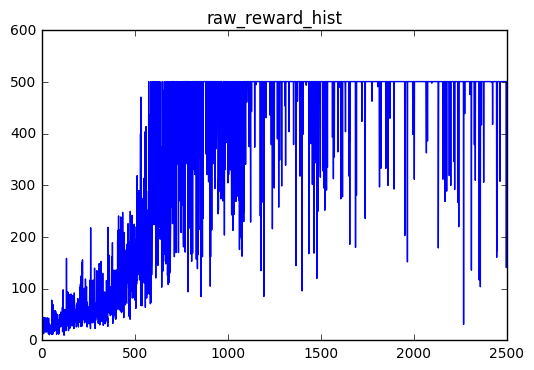

In [13]:
plt.plot(smoothed_pol_loss_hist)
plt.title("pol_loss")
plt.show()

plt.plot(smoothed_val_loss_hist)
plt.title("val_loss")
plt.show()

plt.plot(smoothed_reward_hist)
plt.title("reward_hist")
plt.show()

plt.plot(reward_hist)
plt.title("raw_reward_hist")
plt.show()



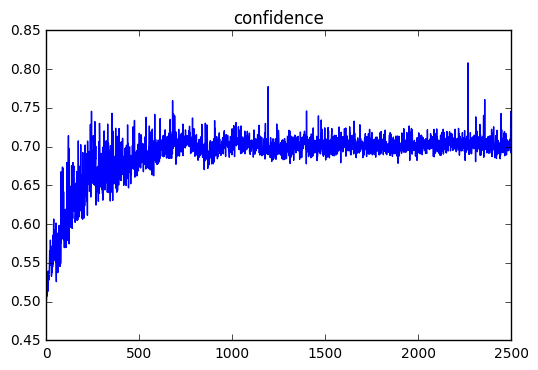

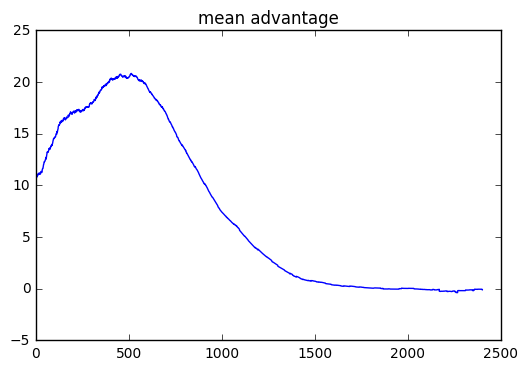

In [15]:
plt.plot(mean_max_prob)
plt.title("confidence")
plt.show()

plt.plot(smoothed_mean_advantage)
plt.title("mean advantage")
plt.show()

episode 0 reward 501.0
episode 25 reward 501.0
episode 50 reward 501.0
episode 75 reward 501.0
episode 100 reward 501.0
episode 125 reward 501.0
episode 150 reward 501.0
episode 175 reward 501.0
episode 200 reward 501.0


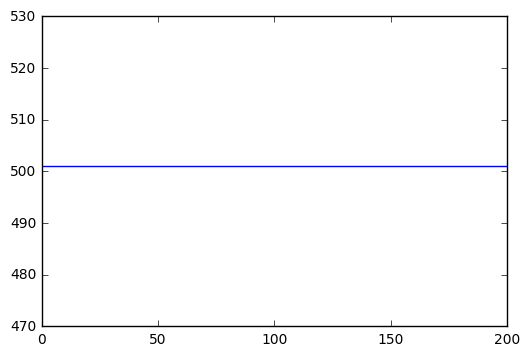

In [8]:
rewards = []
for i in xrange(201):
    obs = env.reset()
    total_reward = 0.0
    while True:
        probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})
        action = 0 if 0.5 < probs[0][0] else 1
        obs, reward, done, _ = env.step(action)
        total_reward += reward
        if done or total_reward > 500:
            break
    rewards.append(total_reward)
    if i % 25 == 0:
        print 'episode', i, 'reward', total_reward

plt.plot(rewards)
plt.show()

In [10]:
#env.monitor.close()